In [33]:
import numpy as np 
import pandas as pd 
import os
import cv2
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def augment_img(file_dir, n_generated_samples, save_dir):
    data_gen = ImageDataGenerator(rotation_range=5, 
                                  width_shift_range=0.05, 
                                  height_shift_range=0.05, 
                                  shear_range=0.02, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True
                                 )

    for filename in listdir(file_dir):
        img = cv2.imread(file_dir + '/' + filename)
        img = img.reshape((1,)+img.shape)
                         
        i=0
        for batch in data_gen.flow(x=img, batch_size=1, save_to_dir=save_dir, save_prefix='aug_img', save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [9]:
img_dir_yes = '/content/drive/My Drive/Colab Notebooks/Brain Tumor Dataset/yes'
img_dir_no = '/content/drive/My Drive/Colab Notebooks/Brain Tumor Dataset/no'
save_dir = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Dataset/augmented_img'

augment_img(file_dir=img_dir_yes,n_generated_samples=6, save_dir=save_dir + '/yes')
augment_img(file_dir=img_dir_no, n_generated_samples=9, save_dir=save_dir + '/no')

In [11]:
def detect_contour(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    return new_image

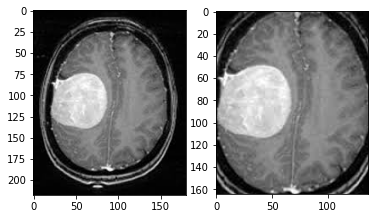

In [12]:
img = cv2.imread(img_dir_yes + '/' + 'Y1.jpg')
cropped_img = detect_contour(img)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(cropped_img)

In [13]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)

            image = detect_contour(image)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)

            image = image / 255.

            X.append(image)

            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [14]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([save_dir+'/yes', save_dir+'/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1960
X shape is: (1960, 240, 240, 3)
y shape is: (1960, 1)


In [15]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)


In [17]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [18]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0     

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
43/43 [==============================] - 121s 3s/step - loss: 0.8324 - accuracy: 0.6173 - val_loss: 0.6929 - val_accuracy: 0.5238
Epoch 2/22
43/43 [==============================] - 119s 3s/step - loss: 0.4659 - accuracy: 0.7821 - val_loss: 0.6332 - val_accuracy: 0.6599
Epoch 3/22
43/43 [==============================] - 120s 3s/step - loss: 0.3806 - accuracy: 0.8397 - val_loss: 0.6140 - val_accuracy: 0.6259
Epoch 4/22
43/43 [==============================] - 121s 3s/step - loss: 0.3184 - accuracy: 0.8695 - val_loss: 0.5646 - val_accuracy: 0.6939
Epoch 5/22
43/43 [==============================] - 121s 3s/step - loss: 0.2775 - accuracy: 0.9009 - val_loss: 0.4857 - val_accuracy: 0.7993
Epoch 6/22
43/43 [==============================] - 121s 3s/step - loss: 0.2538 - accuracy: 0.8965 - val_loss: 0.4768 - val_accuracy: 0.7551
Epoch 7/22
43/43 [==============================] - 121s 3s/step - loss: 0.2181 - accuracy: 0.9271 - val_loss: 0.4082 - val_accuracy: 0.8333
Epoch 8/22
43

In [22]:
model.save('/content/drive/My Drive/Colab Notebooks/Brain Tumor Dataset')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Brain Tumor Dataset/assets


# Plotting Accuracy

In [26]:
history = model.history

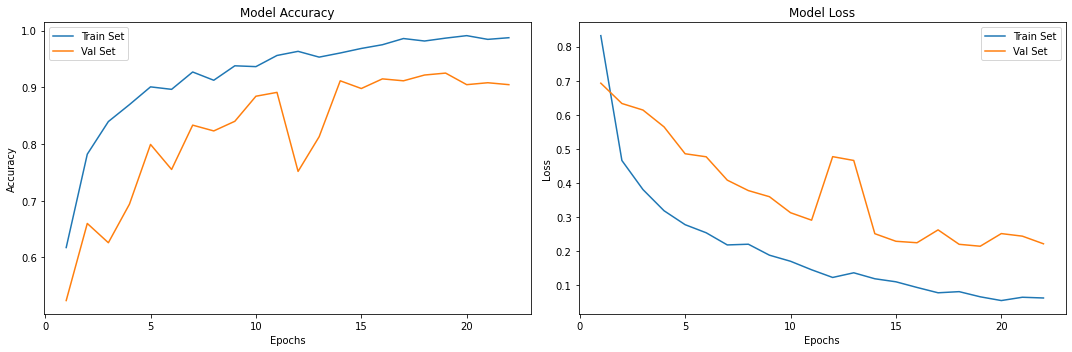

In [27]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

#Result

In [63]:
def preprocess_img(dir, image_size):
    X = []
    image_width, image_height = image_size
    
    image = cv2.imread(dir)
    image = detect_contour(image)
    image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
    # normalize values
    image = image / 255.
    # convert image to numpy array and append it to X
    X.append(image)
    X = np.array(X)

    return X

In [69]:
samp = '/content/drive/My Drive/Colab Notebooks/Brain Tumor Dataset/test/04_23.jpg'
a = preprocess_img(samp, (IMG_WIDTH, IMG_HEIGHT))

In [73]:
predictions = model.predict(a)
predictions = ['Tumor Detected' if x > 0.5 else 'Tumor Not Detected' for x in predictions]
print(predictions)

['Tumor Detected']
